In [1]:
import utils

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import logging

In [2]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 1.15.5
	• tf.keras version: 2.2.4-tf
	• Running on GPU


In [3]:
basedir = os.path.join("C:\\Users\\manos\\git\\metacovid-siamese-neural-network", "dataset", "siamese") 

train_image_list, train_y_list = utils.load_images(basedir, 'train', (100,100))
print("The train set contains",len(train_image_list)) 

valid_image_list, valid_y_list = utils.load_images(basedir, 'validation', (100,100))   
print("The valid set contains", len(valid_image_list))  

test_image_list, test_y_list = utils.load_images(basedir, 'test', (100,100))   
print("The test set contains", len(test_image_list)) 

Found 30 images belonging to 3 classes.
The train set contains 30
Found 30 images belonging to 3 classes.
The valid set contains 30
Found 648 images belonging to 3 classes.
The test set contains 648


In [4]:
# make train pairs
pairs_train, labels_train = utils.make_pairs(train_image_list, train_y_list)

# make validation pairs
pairs_val, labels_val = utils.make_pairs(valid_image_list, valid_y_list)

# make test pairs
pairs_test, labels_test = utils.make_pairs(test_image_list, test_y_list)

x_train_1 = pairs_train[:, 0]  
x_train_2 = pairs_train[:, 1]
print("number of pairs for training", np.shape(x_train_1)[0]) 

x_val_1 = pairs_val[:, 0] 
x_val_2 = pairs_val[:, 1]
print("number of pairs for validation", np.shape(x_val_1)[0]) 

x_test_1 = pairs_test[:, 0] 
x_test_2 = pairs_test[:, 1]
print("number of pairs for test", np.shape(x_test_1)[0]) 

number of pairs for training 60
number of pairs for validation 60
number of pairs for test 1296


In [5]:
tf.compat.v1.reset_default_graph()

SIAMESE_MODEL_FNAME = 'siamese_network.h5'
EMBEDDING_MODEL_FNAME = 'embedding_network.h5'

input_1 = Input((100,100,3))
input_2 = Input((100,100,3))

embedding_network = tf.keras.models.load_model(EMBEDDING_MODEL_FNAME)
embedding_network.trainable = False

model = tf.keras.Sequential() 
for layer in embedding_network.layers:  
    model.add(layer) 

model.add(Flatten(name='flat'))
model.add(Dense(5120, name='den', activation='sigmoid', kernel_regularizer='l2')) 
 
output_1 = model(input_1) 
output_2 = model(input_2) 
 
merge_layer = Lambda(utils.euclidean_distance)([output_1, output_2]) 
output_layer = Dense(1, activation="sigmoid")(merge_layer) 
siamese = Model(inputs=[input_1, input_2], outputs=output_layer) 
siamese.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 5120)         14748995    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

In [6]:
""" callbacks """

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=0.0001)

checkpointer = ModelCheckpoint(filepath='siamese_network.h5', verbose=1, 
                                save_best_only=True)

In [7]:
""" train the model """

optimizer = Adam(learning_rate=0.0001)
siamese.compile(loss=utils.loss(1), optimizer=optimizer, metrics=["accuracy"])
# siamese.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

siamese.summary()
history = siamese.fit([x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=1,
    epochs=175,   # 175 for contrastive 100 for cross ent
    callbacks = [checkpointer, early_stopping, reduce_lr]
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 5120)         14748995    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

Epoch 23/175
59/60 [============================>.] - ETA: 0s - loss: 0.2294 - acc: 0.9153
Epoch 00023: val_loss improved from 0.23706 to 0.23706, saving model to siamese_network.h5
60/60 [==============================] - 7s 124ms/sample - loss: 0.2299 - acc: 0.9167 - val_loss: 0.2371 - val_acc: 0.7833
Epoch 24/175
59/60 [============================>.] - ETA: 0s - loss: 0.2305 - acc: 0.9492- ETA: 0s - loss: 0.2306 - acc: 0.94
Epoch 00024: val_loss improved from 0.23706 to 0.23695, saving model to siamese_network.h5
60/60 [==============================] - 7s 123ms/sample - loss: 0.2299 - acc: 0.9500 - val_loss: 0.2370 - val_acc: 0.7833
Epoch 25/175
59/60 [============================>.] - ETA: 0s - loss: 0.2297 - acc: 0.948 - ETA: 0s - loss: 0.2303 - acc: 0.9492
Epoch 00025: val_loss improved from 0.23695 to 0.23683, saving model to siamese_network.h5
60/60 [==============================] - 7s 123ms/sample - loss: 0.2297 - acc: 0.9500 - val_loss: 0.2368 - val_acc: 0.7833
Epoch 26/17

Epoch 50/175
59/60 [============================>.] - ETA: 0s - loss: 0.2267 - acc: 0.9492
Epoch 00050: val_loss improved from 0.23450 to 0.23431, saving model to siamese_network.h5
60/60 [==============================] - 7s 121ms/sample - loss: 0.2260 - acc: 0.9500 - val_loss: 0.2343 - val_acc: 0.8500
Epoch 51/175
59/60 [============================>.] - ETA: 0s - loss: 0.2253 - acc: 0.9492
Epoch 00051: val_loss improved from 0.23431 to 0.23429, saving model to siamese_network.h5
60/60 [==============================] - 7s 121ms/sample - loss: 0.2259 - acc: 0.9500 - val_loss: 0.2343 - val_acc: 0.8500
Epoch 52/175
59/60 [============================>.] - ETA: 0s - loss: 0.2251 - acc: 0.9492- ETA: 0s - loss: 0.2249 - acc: 
Epoch 00052: val_loss improved from 0.23429 to 0.23411, saving model to siamese_network.h5
60/60 [==============================] - 7s 120ms/sample - loss: 0.2257 - acc: 0.9500 - val_loss: 0.2341 - val_acc: 0.8500
Epoch 53/175
59/60 [============================>.] -

59/60 [============================>.] - ETA: 0s - loss: 0.2211 - acc: 1.0000
Epoch 00077: val_loss improved from 0.23153 to 0.23136, saving model to siamese_network.h5
60/60 [==============================] - 7s 122ms/sample - loss: 0.2219 - acc: 1.0000 - val_loss: 0.2314 - val_acc: 0.9000
Epoch 78/175
59/60 [============================>.] - ETA: 0s - loss: 0.2223 - acc: 0.9831
Epoch 00078: val_loss improved from 0.23136 to 0.23129, saving model to siamese_network.h5
60/60 [==============================] - 7s 122ms/sample - loss: 0.2216 - acc: 0.9833 - val_loss: 0.2313 - val_acc: 0.9000
Epoch 79/175
59/60 [============================>.] - ETA: 0s - loss: 0.2209 - acc: 1.0000
Epoch 00079: val_loss improved from 0.23129 to 0.23113, saving model to siamese_network.h5
60/60 [==============================] - 8s 135ms/sample - loss: 0.2216 - acc: 1.0000 - val_loss: 0.2311 - val_acc: 0.9000
Epoch 80/175
59/60 [============================>.] - ETA: 0s - loss: 0.2220 - acc: 1.0000
Epoch 0

Epoch 104/175
59/60 [============================>.] - ETA: 0s - loss: 0.2181 - acc: 1.0000
Epoch 00104: val_loss improved from 0.22849 to 0.22833, saving model to siamese_network.h5
60/60 [==============================] - 7s 121ms/sample - loss: 0.2174 - acc: 1.0000 - val_loss: 0.2283 - val_acc: 0.9000
Epoch 105/175
59/60 [============================>.] - ETA: 0s - loss: 0.2180 - acc: 1.0000
Epoch 00105: val_loss improved from 0.22833 to 0.22814, saving model to siamese_network.h5
60/60 [==============================] - 7s 122ms/sample - loss: 0.2173 - acc: 1.0000 - val_loss: 0.2281 - val_acc: 0.9000
Epoch 106/175
59/60 [============================>.] - ETA: 0s - loss: 0.2178 - acc: 1.0000
Epoch 00106: val_loss improved from 0.22814 to 0.22802, saving model to siamese_network.h5
60/60 [==============================] - 7s 119ms/sample - loss: 0.2171 - acc: 1.0000 - val_loss: 0.2280 - val_acc: 0.9000
Epoch 107/175
59/60 [============================>.] - ETA: 0s - loss: 0.2177 - ac

Epoch 131/175
59/60 [============================>.] - ETA: 0s - loss: 0.2136 - acc: 1.0000
Epoch 00131: val_loss improved from 0.22519 to 0.22508, saving model to siamese_network.h5
60/60 [==============================] - 7s 122ms/sample - loss: 0.2128 - acc: 1.0000 - val_loss: 0.2251 - val_acc: 0.9000
Epoch 132/175
59/60 [============================>.] - ETA: 0s - loss: 0.2135 - acc: 1.0000
Epoch 00132: val_loss improved from 0.22508 to 0.22491, saving model to siamese_network.h5
60/60 [==============================] - 7s 119ms/sample - loss: 0.2128 - acc: 1.0000 - val_loss: 0.2249 - val_acc: 0.9000
Epoch 133/175
59/60 [============================>.] - ETA: 0s - loss: 0.2119 - acc: 1.0000
Epoch 00133: val_loss improved from 0.22491 to 0.22481, saving model to siamese_network.h5
60/60 [==============================] - 7s 119ms/sample - loss: 0.2126 - acc: 1.0000 - val_loss: 0.2248 - val_acc: 0.9000
Epoch 134/175
59/60 [============================>.] - ETA: 0s - loss: 0.2131 - ac

59/60 [============================>.] - ETA: 0s - loss: 0.2091 - acc: 1.0000
Epoch 00158: val_loss did not improve from 0.22181
60/60 [==============================] - 7s 120ms/sample - loss: 0.2083 - acc: 1.0000 - val_loss: 0.2218 - val_acc: 0.9000
Epoch 159/175
59/60 [============================>.] - ETA: 0s - loss: 0.2089 - acc: 1.0000
Epoch 00159: val_loss improved from 0.22181 to 0.22171, saving model to siamese_network.h5
60/60 [==============================] - 7s 117ms/sample - loss: 0.2081 - acc: 1.0000 - val_loss: 0.2217 - val_acc: 0.9000
Epoch 160/175
59/60 [============================>.] - ETA: 0s - loss: 0.2073 - acc: 1.0000
Epoch 00160: val_loss improved from 0.22171 to 0.22151, saving model to siamese_network.h5
60/60 [==============================] - 7s 122ms/sample - loss: 0.2080 - acc: 1.0000 - val_loss: 0.2215 - val_acc: 0.9000
Epoch 161/175
59/60 [============================>.] - ETA: 0s - loss: 0.2071 - acc: 1.0000
Epoch 00161: val_loss improved from 0.22151 

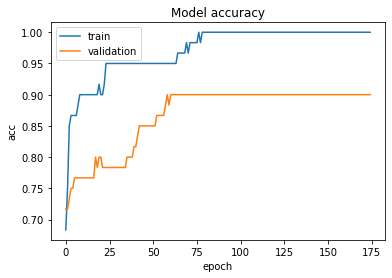

In [8]:
# Plot the accuracy
utils.plt_metric(history=history.history, metric="acc", title="Model accuracy")

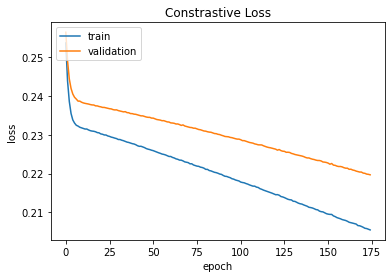

In [9]:
# Plot the constrastive loss
utils.plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [10]:
""" Test the model """
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

1296/1296 [==============================] - 52s 40ms/sample - loss: 0.2094 - acc: 0.9691
test loss, test acc: [0.2094487930521553, 0.9691358]


In [11]:
Y_pred = siamese.predict([x_test_1, x_test_2]).squeeze()
Y_pred

array([0.46319255, 0.4400196 , 0.53185886, ..., 0.37433347, 0.53078866,
       0.36303332], dtype=float32)

In [12]:
Y_pred.mean()

0.44620532

In [24]:
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = Y_pred > .5
y_pred

array([False, False,  True, ..., False,  True, False])

In [25]:
y_test = labels_test
y_test

array([1., 0., 1., ..., 0., 1., 0.], dtype=float32)

In [26]:
print("\nEvaluate on test data")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("ROC AUC:", roc_auc_score(y_test, y_pred, average='weighted'))
print("F1:", f1_score(y_test, y_pred, average='weighted'))


Evaluate on test data
Accuracy: 0.9691358024691358
Precision: 0.9705882352941178
Recall: 0.9691358024691358
ROC AUC: 0.9691358024691358
F1: 0.9691119691119691


In [27]:
cm = confusion_matrix(y_test, y_pred)    
# cm_display = ConfusionMatrixDisplay(cm, labels_test).plot()

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
print("Specificity:", specificity)

Specificity: 0.9969135802469136


In [28]:
tf.keras.backend.clear_session()